In [39]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import pandas as pd

In [40]:
dataset = ""#sklearn"

In [41]:
if "sklearn" in dataset:
    breast_cancer = load_breast_cancer()
    df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
    df["benign"] = breast_cancer.target
else:
    df = pd.read_csv('breast_cancer.csv', delimiter=',' , header=0,encoding='latin-1').dropna()
    X = df.loc[:, df.columns != "Class"]
    original_df = X.copy()
    y = df.loc[:, df.columns == "Class"]
    y = binary_labels = y.map(lambda x: 1 if x == 'recurrence-events' else 0)

In [42]:
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


In [43]:
if "sklearn" in dataset:
    """majority_df = df[df["benign"] == 1]
    minority_df = df[df["benign"] == 0]
    minority_downsampled_df = resample(minority_df, replace=True, n_samples=30, random_state=42)
    downsampled_df = pd.concat([majority_df, minority_downsampled_df])
    downsampled_df["benign"].value_counts()"""
    y = df["benign"]
    X = df.drop("benign", axis=1)
    original_df = X.copy()
else:
    # Encode categorical variables
    le = LabelEncoder()
    df = df.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)


## PCA Plot Generation

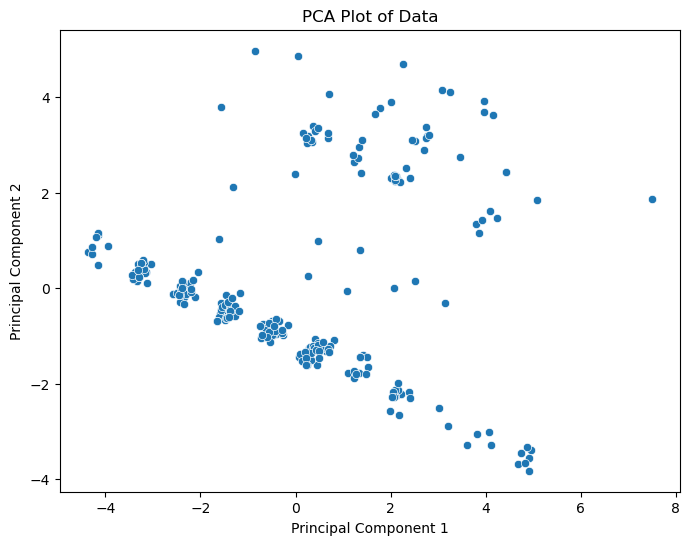

In [44]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)

components = pca.fit_transform(df)

# Create a DataFrame with the reduced dimensions
components_df = pd.DataFrame(data=components, columns=['Component 1', 'Component 2'])

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Component 1', y='Component 2', data=components_df)
plt.title('PCA Plot of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Local Outlier Factor Technique
We use the LocalOutlierFactor technique to find outliers

In [45]:
from sklearn.neighbors import LocalOutlierFactor 
import numpy as np

lof = LocalOutlierFactor(n_neighbors=15) 
lof.fit(df)

# Calculate the outlier scores for each point 
lof_scores = lof.negative_outlier_factor_ 

# Identify the points with the highest outlier scores 
lof_outliers = np.argwhere(lof_scores > np.percentile(lof_scores, 85)) 


In [46]:
# Plot anomly 
def plot_anomaly(outliers, method_name):
    colors=['green','red'] 

    for i in range(components_df.shape[0]): 
        if i not in outliers: 
            plt.scatter(components_df.iloc[i,0], components_df.iloc[i,1], color=colors[0]) # Not anomaly 
    for i in outliers: 
        plt.scatter(components_df.iloc[i,0], components_df.iloc[i,1], color=colors[1]) # anomaly 
    plt.xlabel('Principal Component 1',fontsize=13) 
    plt.ylabel('Principal Component 2',fontsize=13)         
    plt.title('Anomaly by ' + method_name,fontsize=16)         
    plt.show() 

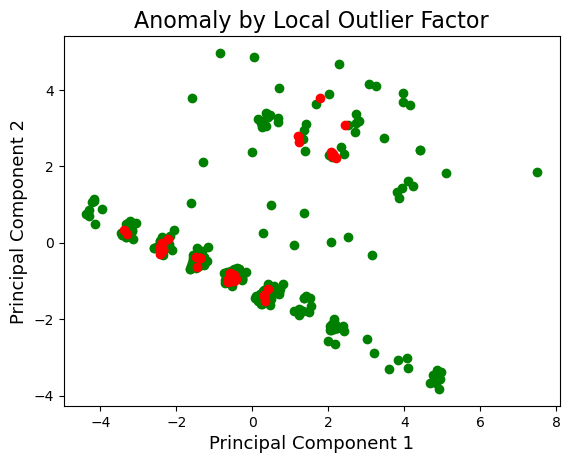

In [47]:
plot_anomaly(lof_outliers, "Local Outlier Factor")

## Isolation Forest Technique
We test and compare with the Isolation Forest technique the outliers found

In [48]:
from sklearn.ensemble import IsolationForest 

model = IsolationForest(contamination=0.05, max_features=0.8, max_samples=0.8, n_estimators=2000, random_state=42) 
model.fit(df) 
#model.fit(components_df)
  
# Calculate the outlier scores for each point 
ir_scores = model.decision_function(df) 
#ir_scores = model.decision_function(components_df) 
  
# Identify the points with the highest outlier scores 
ir_outliers = np.where(ir_scores < 0)[0].tolist() #np.argwhere(ir_scores < np.percentile(ir_scores, 17))
ir_outliers


[35, 41, 64, 74, 99, 107, 117, 138, 174, 203, 211, 231, 255, 262]

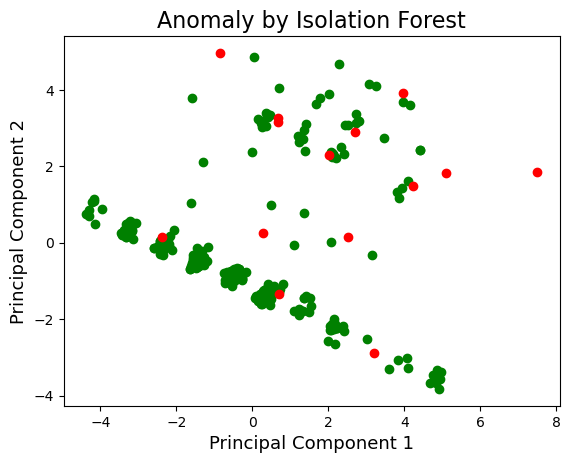

In [49]:
plot_anomaly(ir_outliers, 'Isolation Forest')

## One-class Support Vector Machines (SVMs)

In [50]:
from sklearn import svm 

model = svm.OneClassSVM(nu=0.05) 
model.fit(df) 
  
# Calculate the outlier scores for each point 
svm_scores = model.decision_function(df) 
  
# Identify the points with the highest outlier scores 
svm_outliers = np.argwhere(svm_scores < np.percentile(svm_scores, 15)) 

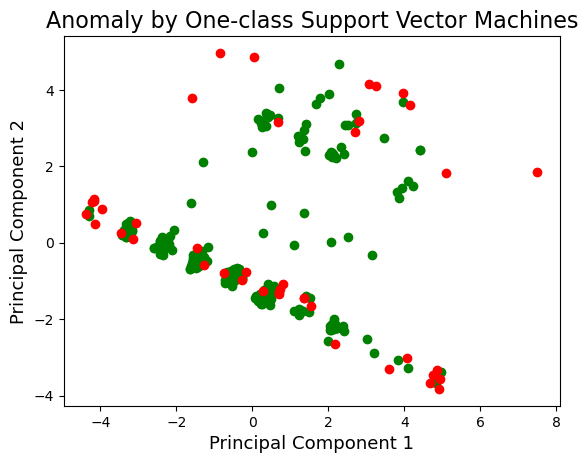

In [51]:
plot_anomaly(svm_outliers, "One-class Support Vector Machines")

# Common Outliers

In [52]:
common_outliers = np.intersect1d(svm_outliers, ir_outliers)
"""
out = [x for x in lof_outliers if x in ir_outliers or x in svm_outliers]
print(out)
out = [x for x in ir_outliers if x in lof_outliers or x in svm_outliers]
print(out)
out = [x for x in svm_outliers if x in ir_outliers or x in lof_outliers]
print(out)"""
print(common_outliers)

[ 35  41  64  74 117 174 231]


# Classification Models

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

def train_model(model, train, labels):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(train.values)

    model = model.fit(encoder.transform(train.values), labels)
    predict_fn = lambda x: model.predict(encoder.transform(x))
    return predict_fn

predict_fn = train_model(RandomForestClassifier(random_state=42), X_train, y_train)
print(predict_fn(X_test.values[:10]))

[0 0 0 0 0 0 0 0 0 0]


c:\Users\Julien Delaunay\.conda\envs\globalEHR\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Explainability Techniques

In [54]:
# Initialize an anchor explainer technique that use decision rules to explain specific decision taken by a classifier
from anchor import utils
from anchor import anchor_tabular

np.random.seed(1)
def generate_explanations(train, test, predict_fn, target_text):
    class_names = ["no-recurrence-events", "recurrence-events"]
    if "sklearn" in dataset:
        categorical_features = []
    else:
        categorical_features = list(range(0, test.shape[1]))
    categorical_names = {}
    temp_data = test.to_numpy()
    for feature in categorical_features:
        le = LabelEncoder()
        le.fit(temp_data[:, feature])
        temp_data[:, feature] = le.transform(temp_data[:, feature])
        categorical_names[feature] = le.classes_

    explainer = anchor_tabular.AnchorTabularExplainer(
        class_names,
        train.columns,
        train.to_numpy(),
        categorical_names
        )
    exp = explainer.explain_instance(target_text, predict_fn, threshold=0.95)
    print('Prediction: ', explainer.class_names[predict_fn(target_text.reshape(1, -1))[0]])
    print('Anchor: %s' % (' AND '.join(exp.names())))

In [55]:
generate_explanations(X_train, X_test, predict_fn, X_test.to_numpy()[0])

Prediction:  no-recurrence-events
Anchor: menopause = ge40 AND inv-nodes = 0-2 AND irradiat = no AND tumor-size = 25-29


# Explain Anomaly Detection

In [56]:
for i, common_outlier in enumerate(common_outliers):
    print("outlier", i)
    print(original_df.iloc[common_outlier].values.reshape(1, -1))
    generate_explanations(X_train, X_test, predict_fn, original_df.iloc[common_outlier].values.reshape(1, -1))
    print()

outlier 0
[['60-69' 'ge40' '45-49' '6-8' 'yes' 3 'left' 'central' 'no']]
Prediction:  no-recurrence-events
Anchor: tumor-size = 45-49 AND irradiat = no AND age = 60-69 AND menopause = ge40 AND breast = left AND breast-quad = central

outlier 1
[['50-59' 'ge40' '20-24' '3-5' 'yes' 3 'right' 'right_up' 'no']]
Prediction:  recurrence-events
Anchor: node-caps = yes AND tumor-size = 20-24 AND deg-malig = 3 AND inv-nodes = 3-5

outlier 2
[['50-59' 'premeno' '50-54' '9-11' 'yes' 2 'right' 'left_up' 'no']]
Prediction:  recurrence-events
Anchor: node-caps = yes AND inv-nodes = 9-11 AND tumor-size = 50-54 AND breast-quad = left_up

outlier 3
[['60-69' 'ge40' '30-34' '6-8' 'yes' 2 'right' 'right_up' 'no']]
Prediction:  no-recurrence-events
Anchor: tumor-size = 30-34 AND deg-malig = 3 AND irradiat = no AND menopause = ge40 AND breast = right

outlier 4
[['30-39' 'premeno' '35-39' '9-11' 'yes' 3 'left' 'left_low' 'no']]
Prediction:  recurrence-events
Anchor: node-caps = yes AND inv-nodes = 9-11 AND

In [57]:
print(original_df.iloc[common_outliers].values)

[['60-69' 'ge40' '45-49' '6-8' 'yes' 3 'left' 'central' 'no']
 ['50-59' 'ge40' '20-24' '3-5' 'yes' 3 'right' 'right_up' 'no']
 ['50-59' 'premeno' '50-54' '9-11' 'yes' 2 'right' 'left_up' 'no']
 ['60-69' 'ge40' '30-34' '6-8' 'yes' 2 'right' 'right_up' 'no']
 ['30-39' 'premeno' '35-39' '9-11' 'yes' 3 'left' 'left_low' 'no']
 ['60-69' 'ge40' '10-14' '6-8' 'yes' 3 'left' 'left_up' 'yes']
 ['60-69' 'ge40' '30-34' '0-2' 'yes' 2 'right' 'right_up' 'yes']]
